newyork taxt data analysis: https://github.com/swapnanilsharma/Taxi-demand-prediction-in-New-York-City/blob/master/NYC%20Final.ipynb

In [1]:
import matplotlib.pyplot as plt
import dask.dataframe as dd#similar to pandas
import pandas as pd
import datetime #Convert to unix time
import time #Convert to unix 
import numpy as np
import seaborn as sns#Plots
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

In [2]:
# 데이터 열기
pd.set_option('display.max_columns', None)

month = pd.read_parquet('yellow_tripdata_2018-01.parquet',engine='pyarrow')

print(month)

         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               1  2018-01-01 00:21:05   2018-01-01 00:24:23                1   
1               1  2018-01-01 00:44:55   2018-01-01 01:03:05                1   
2               1  2018-01-01 00:08:26   2018-01-01 00:14:21                2   
3               1  2018-01-01 00:20:22   2018-01-01 00:52:51                1   
4               1  2018-01-01 00:09:18   2018-01-01 00:27:06                2   
...           ...                  ...                   ...              ...   
8760682         1  2018-01-31 23:21:35   2018-01-31 23:34:20                2   
8760683         1  2018-01-31 23:35:51   2018-01-31 23:38:57                1   
8760684         2  2018-01-31 23:28:00   2018-01-31 23:37:09                1   
8760685         2  2018-01-31 23:24:40   2018-01-31 23:25:28                1   
8760686         2  2018-01-31 23:28:16   2018-01-31 23:28:38                1   

         trip_distance  Rat

In [34]:
month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               0 non-null      int64         
 1   tpep_pickup_datetime   0 non-null      datetime64[ns]
 2   tpep_dropoff_datetime  0 non-null      datetime64[ns]
 3   passenger_count        0 non-null      int64         
 4   trip_distance          0 non-null      float64       
 5   RatecodeID             0 non-null      int64         
 6   store_and_fwd_flag     0 non-null      object        
 7   PULocationID           0 non-null      int64         
 8   DOLocationID           0 non-null      int64         
 9   payment_type           0 non-null      int64         
 10  fare_amount            0 non-null      float64       
 11  extra                  0 non-null      float64       
 12  mta_tax                0 non-null      float64       
 13  tip_amount       

In [27]:
# 널값 아닌 데이터 수
month.notnull().sum()

VendorID                 8760687
tpep_pickup_datetime     8760687
tpep_dropoff_datetime    8760687
passenger_count          8760687
trip_distance            8760687
RatecodeID               8760687
store_and_fwd_flag       8760687
PULocationID             8760687
DOLocationID             8760687
payment_type             8760687
fare_amount              8760687
extra                    8760687
mta_tax                  8760687
tip_amount               8760687
tolls_amount             8760687
improvement_surcharge    8760687
total_amount             8760687
congestion_surcharge          12
airport_fee                   12
dtype: int64

In [28]:
print(month.shape)

(8760687, 19)


In [46]:
# 상위 값 5개
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee


In [3]:
# 지역 번호 파일 열기
location_zone_csv = pd.read_csv("./taxi+_zone_lookup.csv")
print(location_zone_csv)

     LocationID        Borough                     Zone service_zone
0             1            EWR           Newark Airport          EWR
1             2         Queens              Jamaica Bay    Boro Zone
2             3          Bronx  Allerton/Pelham Gardens    Boro Zone
3             4      Manhattan            Alphabet City  Yellow Zone
4             5  Staten Island            Arden Heights    Boro Zone
..          ...            ...                      ...          ...
260         261      Manhattan       World Trade Center  Yellow Zone
261         262      Manhattan           Yorkville East  Yellow Zone
262         263      Manhattan           Yorkville West  Yellow Zone
263         264        Unknown                       NV          NaN
264         265        Unknown                      NaN          NaN

[265 rows x 4 columns]


In [4]:
# 맨해튼 지역 번호 추출
manhattan = location_zone_csv[location_zone_csv['Borough'] == 'Manhattan']
manhattan_number = manhattan['LocationID']

In [53]:
print(manhattan_number)

3        4
11      12
12      13
23      24
40      41
      ... 
245    246
248    249
260    261
261    262
262    263
Name: LocationID, Length: 69, dtype: int64


In [58]:
print(month)

         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               1  2018-01-01 00:21:05   2018-01-01 00:24:23                1   
1               1  2018-01-01 00:44:55   2018-01-01 01:03:05                1   
2               1  2018-01-01 00:08:26   2018-01-01 00:14:21                2   
3               1  2018-01-01 00:20:22   2018-01-01 00:52:51                1   
4               1  2018-01-01 00:09:18   2018-01-01 00:27:06                2   
...           ...                  ...                   ...              ...   
8760682         1  2018-01-31 23:21:35   2018-01-31 23:34:20                2   
8760683         1  2018-01-31 23:35:51   2018-01-31 23:38:57                1   
8760684         2  2018-01-31 23:28:00   2018-01-31 23:37:09                1   
8760685         2  2018-01-31 23:24:40   2018-01-31 23:25:28                1   
8760686         2  2018-01-31 23:28:16   2018-01-31 23:28:38                1   

         trip_distance  Rat

In [5]:
# 맨해튼 지역번호 추출

manhattan_arr_data = []
for i in manhattan_number.values:
    #print(i)
    manhattan_arr_data.append(month[month['PULocationID'] == i])

In [6]:
manhattan_data = pd.concat(manhattan_arr_data, axis=0, ignore_index=True)

In [7]:
manhattan_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2018-01-01 00:08:10,2018-01-01 00:12:53,4,0.7,1,N,4,232,2,5.0,0.5,0.5,0.00,0.0,0.3,6.30,NaN,NaN
1,1,2018-01-01 00:35:41,2018-01-01 00:44:15,1,0.8,1,N,4,148,1,7.0,0.5,0.5,1.25,0.0,0.3,9.55,NaN,NaN
2,1,2018-01-01 00:57:14,2018-01-01 01:02:57,2,1.1,1,N,4,224,2,6.0,0.5,0.5,0.00,0.0,0.3,7.30,NaN,NaN
3,1,2018-01-01 00:20:47,2018-01-01 00:28:29,1,0.9,1,N,4,232,2,6.5,0.5,0.5,0.00,0.0,0.3,7.80,NaN,NaN
4,1,2018-01-01 00:34:01,2018-01-01 00:54:18,1,2.9,1,N,4,68,2,14.5,0.5,0.5,0.00,0.0,0.3,15.80,NaN,NaN


In [72]:
manhattan_data.shape

(7966454, 19)

1. time

In [8]:
# def convert_to_unix(s):

#     return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())
    
def return_with_trip_times(month):
    # 탑승, 하차 시간 가져오기
    duration = month[['tpep_pickup_datetime', 'tpep_dropoff_datetime']]
    # unix time으로 변환
    duration_pickup = [x for x in duration['tpep_pickup_datetime'].values]
    duration_dropoff = [x for x in duration['tpep_dropoff_datetime'].values]
    
    # 이동 시간(분)
    onemin = pd.Timedelta(minutes=1)
    durations = (np.array(duration_dropoff) - np.array(duration_pickup)) / onemin
    #print(durations)

    new_frame = month[['passenger_count','trip_distance','PULocationID','DOLocationID', 'total_amount', 'tip_amount']]

    # 이동 시간과 이동 속도를 담은 새 데이터 생성    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    # /hour로 변환
    new_frame['speed'] = 60 * (new_frame['trip_distance']/new_frame['trip_times'])

    return new_frame

frame_with_durations = return_with_trip_times(manhattan_data)


C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\161970395.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['trip_times'] = durations
C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\161970395.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['pickup_times'] = duration_pickup
C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\161970395.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

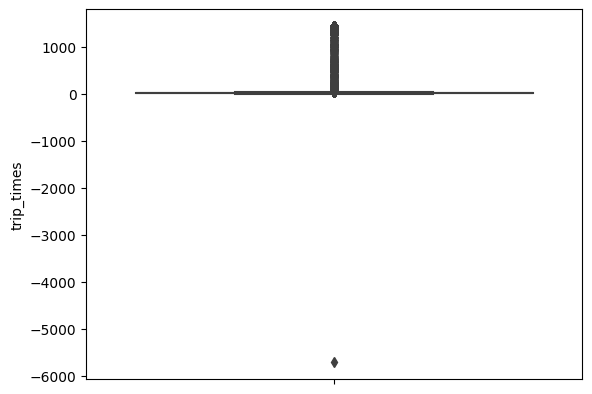

In [74]:
# 분단위
sns.boxplot(y="trip_times", data=frame_with_durations)
plt.show()

In [75]:
# 10%마다 해당되는 시간
for i in range(0, 100, 10):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value id ", var[-1])
# 양 끝쪽에 튀는 데이터 존재

0 percentile value is -5711.583333333333
10 percentile value is 3.85
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.933333333333334
60 percentile value is 11.833333333333334
70 percentile value is 14.183333333333334
80 percentile value is 17.416666666666668
90 percentile value is 22.8
100 percentile value id  1439.9833333333333


In [76]:
# 90%~100%마다 해당되는 시간
for i in range(90, 100):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value id ", var[-1])

90 percentile value is 22.8
91 percentile value is 23.616666666666667
92 percentile value is 24.516666666666666
93 percentile value is 25.566666666666666
94 percentile value is 26.766666666666666
95 percentile value is 28.2
96 percentile value is 30.016666666666666
97 percentile value is 32.45
98 percentile value is 36.13333333333333
99 percentile value is 43.81666666666667
100 percentile value id  1439.9833333333333


In [77]:
# 0%~10%마다 해당되는 시간
for i in range(0, 11):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))

0 percentile value is -5711.583333333333
1 percentile value is 1.4333333333333333
2 percentile value is 1.9833333333333334
3 percentile value is 2.35
4 percentile value is 2.6333333333333333
5 percentile value is 2.8666666666666667
6 percentile value is 3.1
7 percentile value is 3.3
8 percentile value is 3.4833333333333334
9 percentile value is 3.6666666666666665
10 percentile value is 3.85


In [9]:
# 시간이 이상하게 튀는 값 삭제(12시간까지) -> 더 줄여도될듯?
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]
print(frame_with_durations_modified.shape)

(7905927, 9)


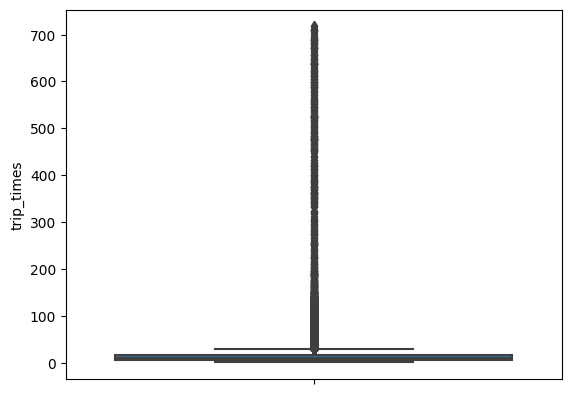

In [81]:
sns.boxplot(y="trip_times", data=frame_with_durations_modified)
plt.show()
# 왜 최댓값 30대???
# -> 1사분위수, 3사분위수에서 상자 길이의 1.5배 떨어진 거리가 최소, 최대값을 의미

c:\Users\sktmd\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


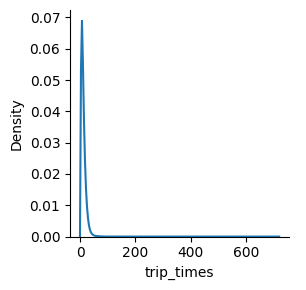

In [82]:
sns.FacetGrid(frame_with_durations_modified) \
    .map(sns.kdeplot, "trip_times") \
    .add_legend()
plt.show()

In [10]:
import math
frame_with_durations_modified['log_times'] = [math.log(i) for i in frame_with_durations_modified['trip_times'].values]


C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\2641135077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_with_durations_modified['log_times'] = [math.log(i) for i in frame_with_durations_modified['trip_times'].values]


c:\Users\sktmd\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


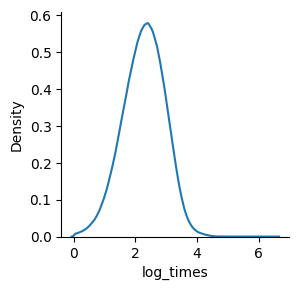

In [84]:
sns.FacetGrid(frame_with_durations_modified) \
    .map(sns.kdeplot, "log_times") \
    .add_legend()
plt.show()

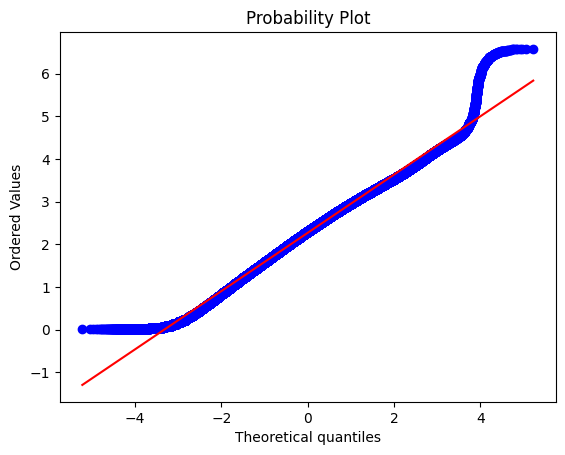

In [85]:
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()
# probplot ->  파란 점들이 빨간 선에 가까울수록 정규 분포를 띔

2. speed

C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\3401238407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_with_durations_modified['speed'] = 60 * (frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])


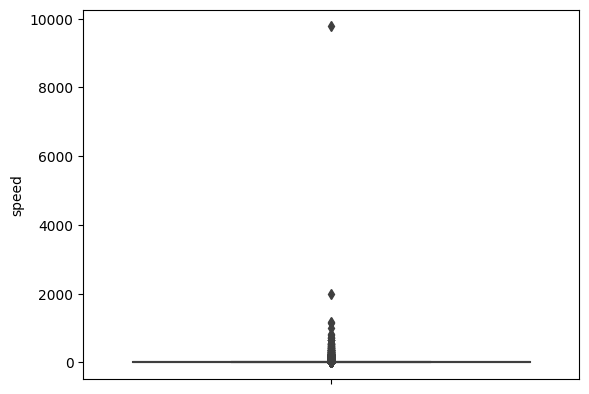

In [11]:
frame_with_durations_modified['speed'] = 60 * (frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="speed", data=frame_with_durations_modified)
plt.show()

In [87]:
for i in range(0, 100, 10):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

0 percentile value is 0.0
10 percentile value is 5.669291338582677
20 percentile value is 6.881118881118881
30 percentile value is 7.847411444141691
40 percentile value is 8.758002560819461
50 percentile value is 9.695916594265855
60 percentile value is 10.741258741258742
70 percentile value is 12.0
80 percentile value is 13.764705882352942
90 percentile value is 16.896
100 percentile value is 9774.117647058823


In [88]:
for i in range(90, 100):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])
# 끝 쪽에 튀는 값 존재

90 percentile value is 16.896
91 percentile value is 17.401812688821753
92 percentile value is 17.98918918918919
93 percentile value is 18.64693446088795
94 percentile value is 19.442345276872963
95 percentile value is 20.40302267002519
96 percentile value is 21.606710158434296
97 percentile value is 23.18744838976053
98 percentile value is 25.376288659793815
99 percentile value is 29.02687673772011
100 percentile value is 9774.117647058823


In [89]:
for i in range(0, 11):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])
# 끝쪽에 튀는 값 존재

0 percentile value is 0.0
1 percentile value is 3.214723926380368
2 percentile value is 3.8176033934252382
3 percentile value is 4.207011686143573
4 percentile value is 4.506258692628651
5 percentile value is 4.757709251101322
6 percentile value is 4.976958525345622
7 percentile value is 5.173396674584323
8 percentile value is 5.351351351351352
9 percentile value is 5.515832482124617
10 percentile value is 5.669291338582677
100 percentile value is 9774.117647058823


In [90]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is", var[-1])

99.0 percentile value is 29.02687673772011
99.1 percentile value is 29.577464788732396
99.2 percentile value is 30.186770428015564
99.3 percentile value is 30.874400767018216
99.4 percentile value is 31.656082071323887
99.5 percentile value is 32.54237288135593
99.6 percentile value is 33.60703812316716
99.7 percentile value is 34.955863808322825
99.8 percentile value is 36.74703557312253
99.9 percentile value is 39.55748031496063
100 percentile value is 9774.117647058823


In [12]:
frame_with_durations_modified = frame_with_durations_modified[(frame_with_durations_modified.speed>0) & (frame_with_durations_modified.speed < 50)]

In [92]:
# 평균 속도
sum(frame_with_durations_modified['speed']) / float(len(frame_with_durations_modified['speed']))

10.733153400996526

3. trip distance

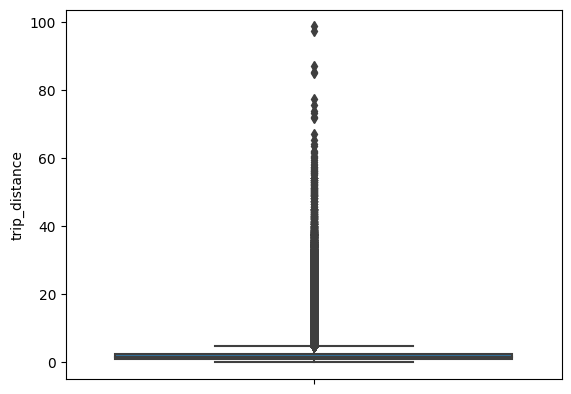

In [93]:
sns.boxplot(y="trip_distance", data=frame_with_durations_modified)
plt.show()

In [94]:
for i in range(0, 100, 10):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

0 percentile value is 0.01
10 percentile value is 0.6
20 percentile value is 0.8
30 percentile value is 1.0
40 percentile value is 1.21
50 percentile value is 1.5
60 percentile value is 1.8
70 percentile value is 2.21
80 percentile value is 2.9
90 percentile value is 4.5
100 percentile value is 98.7


In [95]:
for i in range(90, 100):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

90 percentile value is 4.5
91 percentile value is 4.8
92 percentile value is 5.16
93 percentile value is 5.54
94 percentile value is 6.01
95 percentile value is 6.6
96 percentile value is 7.42
97 percentile value is 8.69
98 percentile value is 10.3
99 percentile value is 14.5
100 percentile value is 98.7


In [96]:
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 14.5
99.1 percentile value is 15.59
99.2 percentile value is 16.3
99.3 percentile value is 16.74
99.4 percentile value is 17.1
99.5 percentile value is 17.5
99.6 percentile value is 17.9
99.7 percentile value is 18.52
99.8 percentile value is 19.51
99.9 percentile value is 20.97
100 percentile value is  98.7


In [13]:
frame_with_durations_modified = frame_with_durations_modified[(frame_with_durations_modified.trip_distance>0) & (frame_with_durations_modified.trip_distance<30)]

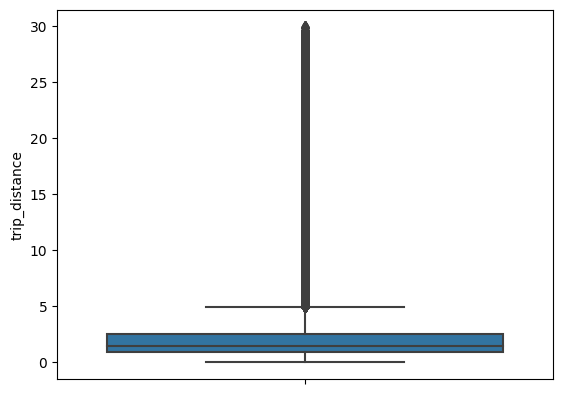

In [98]:
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

4. total fare

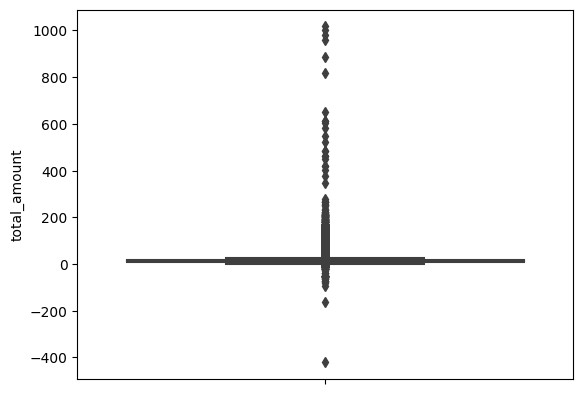

In [99]:
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [123]:
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -420.8
10 percentile value is 6.36
20 percentile value is 7.56
30 percentile value is 8.76
40 percentile value is 9.8
50 percentile value is 11.0
60 percentile value is 12.35
70 percentile value is 14.16
80 percentile value is 17.15
90 percentile value is 22.3
100 percentile value is  1017.3


In [101]:
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 22.3
91 percentile value is 23.3
92 percentile value is 24.35
93 percentile value is 25.56
94 percentile value is 27.0
95 percentile value is 28.99
96 percentile value is 31.56
97 percentile value is 35.76
98 percentile value is 42.56
99 percentile value is 57.3
100 percentile value is  1017.3


In [124]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 57.3
99.1 percentile value is 58.56
99.2 percentile value is 60.54
99.3 percentile value is 63.35
99.4 percentile value is 66.0
99.5 percentile value is 70.26
99.6 percentile value is 70.27
99.7 percentile value is 73.2
99.8 percentile value is 78.82
99.9 percentile value is 94.56
100 percentile value is  1017.3


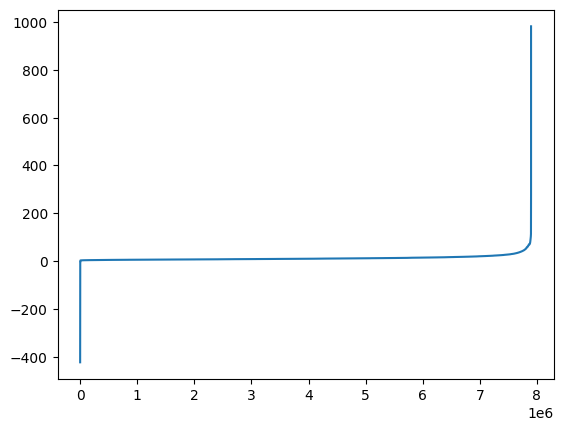

In [125]:
plt.plot(var[:-2])
plt.show()
# 끝값에서 튄다 -> 아직 이상한 값 존재

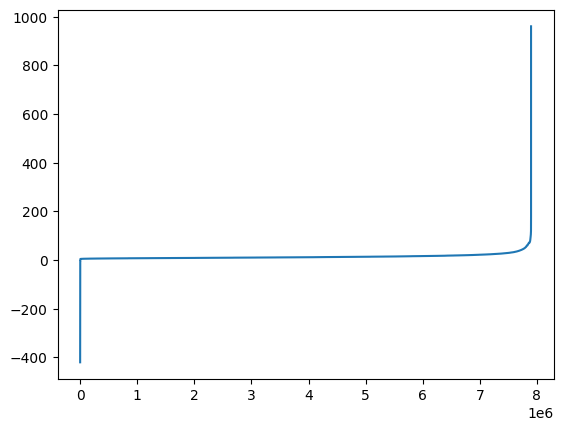

In [104]:
plt.plot(var[:-3])
plt.show()
# 끝값에서 튄다 -> 아직 이상한 값 존재

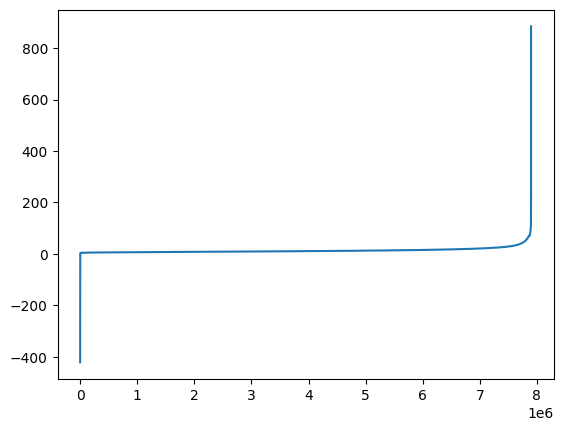

In [126]:
plt.plot(var[:-4])
plt.show()
# 끝값에서 튄다 -> 아직 이상한 값 존재

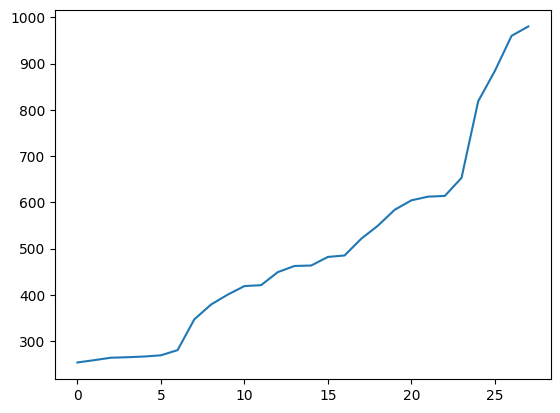

In [132]:
plt.plot(var[-30:-2])
plt.show()
# 1000언저리에서 끊어야함

5. tip_amount

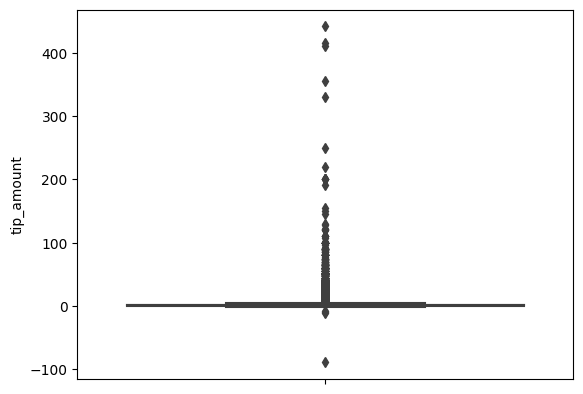

In [133]:
sns.boxplot(y="tip_amount", data =frame_with_durations_modified)
plt.show()

In [134]:
for i in range(0,100,10):
    var = frame_with_durations_modified["tip_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -88.8
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 1.0
50 percentile value is 1.36
60 percentile value is 1.7
70 percentile value is 2.0
80 percentile value is 2.5
90 percentile value is 3.36
100 percentile value is  441.71


In [135]:
for i in range(90,100,1):
    var = frame_with_durations_modified["tip_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 3.36
91 percentile value is 3.55
92 percentile value is 3.75
93 percentile value is 3.96
94 percentile value is 4.16
95 percentile value is 4.55
96 percentile value is 4.96
97 percentile value is 5.36
98 percentile value is 6.45
99 percentile value is 8.64
100 percentile value is  441.71


In [136]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["tip_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 8.64
99.1 percentile value is 9.08
99.2 percentile value is 9.76
99.3 percentile value is 10.0
99.4 percentile value is 10.56
99.5 percentile value is 11.46
99.6 percentile value is 11.71
99.7 percentile value is 12.3
99.8 percentile value is 14.6
99.9 percentile value is 16.46
100 percentile value is  441.71


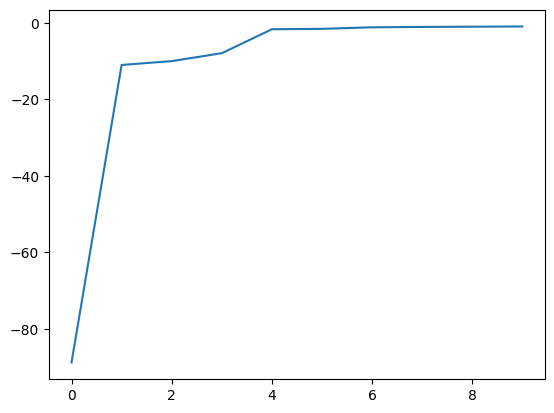

In [161]:
plt.plot(var[0:10])
plt.show()
# 1100언저리에서 끊어야함

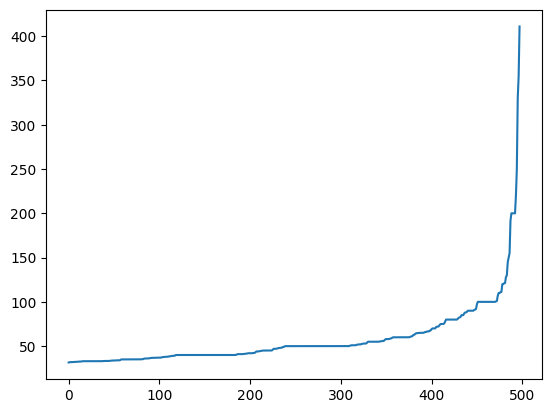

In [159]:
plt.plot(var[-500:-2])
plt.show()
# 1100언저리에서 끊어야함

In [14]:
# 1. 이상한 시간
# 2. 이상한 속도
# 3. 이상한 거리
# 4. 이상한 비용
# 5. 이상한 팁
def remove_outliers(new_frame):
    a = new_frame.shape[0]
    print("총 데이터 수 = ", a)

    # 시간
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("시간 튀는 값의 개수:",(a-c))
    
    # 거리
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 30)]
    d = temp_frame.shape[0]
    print ("거리 튀는 값의 개수:",(a-d))

    # 속도
    temp_frame = new_frame[(new_frame.speed <= 50) & (new_frame.speed >= 0)]
    e = temp_frame.shape[0]
    print ("속도 튀는 값의 개수",(a-e))

    # 비용
    temp_frame = new_frame[(new_frame.total_amount <650) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("비용 튀는 값의 개수:",(a-f))

    # 팁
    # haptemp_frame = new_frame[(new_frame.tip_amount <500) & (new_frame.tip_amount >0)]
    # g = temp_frame.se[0]
    # print ("팁 튀는 값의 개수:",(a-g))

    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 120)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 30)]
    new_frame = new_frame[(new_frame.speed < 50) & (new_frame.speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <650) & (new_frame.total_amount >0)]
    # new_frame = new_frame[(new_frame.tip_amount <500.0) & (new_frame.tip_amount >0.0)]

    print("전체 삭제 된 데이터 수", a-new_frame.shape[0])
    print("---")
    return new_frame

In [15]:
print("2018-01 데이터 제거 현황")
print("---")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("튀는 값 제거하고 남은 비율", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

2018-01 데이터 제거 현황
---
총 데이터 수 =  7966454
시간 튀는 값의 개수: 19633
거리 튀는 값의 개수: 31431
속도 튀는 값의 개수 10515
비용 튀는 값의 개수: 3638
전체 삭제 된 데이터 수 53919
---
튀는 값 제거하고 남은 비율 0.9932317440105723


맨해튼 지역번호 -> 순차 번호로 바꾸기

In [189]:
frame_with_durations_outliers_removed.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,tip_amount,trip_times,pickup_times,speed
0,4,0.7,4,232,6.30,0.00,4.716667,2018-01-01 00:08:10,8.904594
1,1,0.8,4,148,9.55,1.25,8.566667,2018-01-01 00:35:41,5.603113
2,2,1.1,4,224,7.30,0.00,5.716667,2018-01-01 00:57:14,11.545190
3,1,0.9,4,232,7.80,0.00,7.700000,2018-01-01 00:20:47,7.012987
4,1,2.9,4,68,15.80,0.00,20.283333,2018-01-01 00:34:01,8.578472


In [16]:

for location_id, index in zip(manhattan_number, range(1, len(manhattan_number)+1)):
    frame_with_durations_outliers_removed.loc[frame_with_durations_outliers_removed['PULocationID'] == location_id, 'PULocationID'] = index
frame_with_durations_outliers_removed
    

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,tip_amount,trip_times,pickup_times,speed
0,4,0.70,1,232,6.30,0.00,4.716667,2018-01-01 00:08:10,8.904594
1,1,0.80,1,148,9.55,1.25,8.566667,2018-01-01 00:35:41,5.603113
2,2,1.10,1,224,7.30,0.00,5.716667,2018-01-01 00:57:14,11.545190
3,1,0.90,1,232,7.80,0.00,7.700000,2018-01-01 00:20:47,7.012987
4,1,2.90,1,68,15.80,0.00,20.283333,2018-01-01 00:34:01,8.578472
...,...,...,...,...,...,...,...,...,...
7966448,2,1.76,69,74,8.80,0.00,6.716667,2018-01-31 23:25:32,15.722084
7966449,2,0.80,69,237,5.80,0.00,2.416667,2018-01-31 23:43:29,19.862069
7966451,5,2.08,69,238,13.30,2.00,10.500000,2018-01-31 23:39:43,11.885714
7966452,2,3.61,69,42,17.16,2.86,13.383333,2018-01-31 23:17:18,16.184309



-----------------------------------------------------------------
1. 시간 구간 구해서 그룹핑(클러스터링은 이미 되어 있으므로 생략)

In [17]:
# Refer:https://www.unixtimestamp.com/
# 1514732400 : 2018-01-01 00:00:00 
# 1517410800 : 2018-02-01 00:00:00 
# 1519830000 : 2018-03-01 00:00:00
# 1522508400 : 2018-04-01 00:00:00 
# 1525100400 : 2018-05-01 00:00:00 
# 1527778800 : 2018-06-01 00:00:00

# 1546268400 : 2019-01-01 00:00:00 
# 1548946800 : 2019-02-01 00:00:00 
# 1551366000 : 2019-03-01 00:00:00
# 1554044400 : 2019-04-01 00:00:00 
# 1556636400 : 2019-05-01 00:00:00 
# 1559314800 : 2019-06-01 00:00:00

def add_pickup_bins(frame, month, year):
    # 탑승 시간에 대한 배열
    unix_pickup_times = [i for i in frame['pickup_times'].values]
    unix_times = [[1514732400, 1517410800, 151983000, 1522508400, 1525100400, 1527778800], \
        [1546268400, 1548946800, 1551366000, 1554044400, 1556636400, 1559314800]]

    # 해당하는 년도와 월에 대한 시간
    start_pickup_unix = unix_times[year-2018][month-1]
    # (int((i-start_pickup_unix)/600)+33) : est 표준 시간 -> gmt 표준 시간(미국 동부)
    # 해당 년도 월에 대해서 10분 간격으로 나누기
    onehour_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/3600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(onehour_binned_unix_pickup_times)
    return frame

In [18]:
jan_2018_frame = add_pickup_bins(frame_with_durations_outliers_removed, 1, 2018)

C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\606180926.py:26: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  onehour_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/3600)+33) for i in unix_pickup_times]


In [19]:
# 2018년도 1월 시간과 지역별 그룹화
jan_2018_groupby = jan_2018_frame[['PULocationID', 'pickup_bins', 'trip_distance']].groupby(['PULocationID', 'pickup_bins']).count()

In [194]:
jan_2018_frame.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,tip_amount,trip_times,pickup_times,speed,pickup_bins
0,4,0.7,1,232,6.30,0.00,4.716667,2018-01-01 00:08:10,8.904594,42
1,1,0.8,1,148,9.55,1.25,8.566667,2018-01-01 00:35:41,5.603113,42
2,2,1.1,1,224,7.30,0.00,5.716667,2018-01-01 00:57:14,11.545190,42
3,1,0.9,1,232,7.80,0.00,7.700000,2018-01-01 00:20:47,7.012987,42
4,1,2.9,1,68,15.80,0.00,20.283333,2018-01-01 00:34:01,8.578472,42


In [195]:
jan_2018_groupby.head()

trip_distance
PULocationID pickup_bins               
1            30                       1
             36                       1
             41                       2
             42                     498
             43                     437

In [20]:
# 앞까지 했던 방식을 2019-1, 2019-2, 2019-3에 대해 똑같이 적용
def datapreparation(month, month_no, year_no):

    print("return_with_trip_times..")
    frame_with_durations = return_with_trip_times(month)

    print("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)

    print('Final groupying')
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed, month_no, year_no)
    final_groupby_frame = final_updated_frame[['PULocationID', 'pickup_bins', 'trip_distance']].groupby(['PULocationID', 'pickup_bins']).count()

    return final_updated_frame, final_groupby_frame


month_jan_2019 = pd.read_parquet('yellow_tripdata_2019-01.parquet',engine='pyarrow')
month_feb_2019 = pd.read_parquet('yellow_tripdata_2019-02.parquet',engine='pyarrow')
month_mar_2019 = pd.read_parquet('yellow_tripdata_2019-03.parquet',engine='pyarrow')

jan_2019_frame, jan_2019_groupby = datapreparation(month_jan_2019, 1, 2019)
feb_2019_frame, feb_2019_groupby = datapreparation(month_feb_2019, 2, 2019)
mar_2019_frame, mar_2019_groupby = datapreparation(month_mar_2019, 3, 2019)

return_with_trip_times..


C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\161970395.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['trip_times'] = durations
C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\161970395.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['pickup_times'] = duration_pickup
C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\161970395.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Remove outliers..
총 데이터 수 =  7696617
시간 튀는 값의 개수: 26502
거리 튀는 값의 개수: 58240
속도 튀는 값의 개수 15120
비용 튀는 값의 개수: 8804
전체 삭제 된 데이터 수 93759
---
Final groupying


C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\606180926.py:26: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  onehour_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/3600)+33) for i in unix_pickup_times]


return_with_trip_times..


C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\161970395.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['trip_times'] = durations
C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\161970395.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['pickup_times'] = duration_pickup
C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\161970395.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Remove outliers..
총 데이터 수 =  7049370
시간 튀는 값의 개수: 24120
거리 튀는 값의 개수: 52741
속도 튀는 값의 개수 13949
비용 튀는 값의 개수: 11266
전체 삭제 된 데이터 수 87358
---
Final groupying


C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\606180926.py:26: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  onehour_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/3600)+33) for i in unix_pickup_times]


return_with_trip_times..


C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\161970395.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['trip_times'] = durations
C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\161970395.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['pickup_times'] = duration_pickup
C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\161970395.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Remove outliers..
총 데이터 수 =  7866620
시간 튀는 값의 개수: 25795
거리 튀는 값의 개수: 57473
속도 튀는 값의 개수 15025
비용 튀는 값의 개수: 13588
전체 삭제 된 데이터 수 97537
---
Final groupying


C:\Users\sktmd\AppData\Local\Temp\ipykernel_16528\606180926.py:26: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  onehour_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/3600)+33) for i in unix_pickup_times]


2. smoothing(평활화)
-> 데이터가 없는 구간 확인
-> 0으로 채워주고, 평균값으로 설정

In [21]:
print(jan_2018_groupby)

                          trip_distance
PULocationID pickup_bins               
1            42                      85
             43                     154
             44                     149
             45                      99
             46                      76
...                                 ...
69           781                    318
             782                    247
             783                    309
             784                    221
             785                    102

[45377 rows x 1 columns]


In [22]:
# 각 지역마다 데이터가 존재하는  시간대 리스트 구하기

def return_unq_pickup_bins(frame):
    values = []
    for i in range(1, 70): # 265개의 PULocationID
        new = frame[frame['PULocationID'] == i] # 지역별
        list_unq = list(set(new['pickup_bins'])) # pickup이 존재하는 시간 리스트
        list_unq.sort()
        values.append(list_unq) # 시간대마다 values에 누적
    return values

In [23]:
#jan
jan_2018_unique = return_unq_pickup_bins(jan_2018_frame)
jan_2019_unique = return_unq_pickup_bins(jan_2019_frame)

#feb
feb_2019_unique = return_unq_pickup_bins(feb_2019_frame)

#march
mar_2019_unique = return_unq_pickup_bins(mar_2019_frame)

In [24]:
# 31일 * 24시간 * 60분 / 60분 = 744
for i in range(1, 70):
    print(i, "번째 구역에서 1시간 간격안에 픽업 데이터가 없는 경우의 개수", 744-len(set(jan_2018_unique[i-1])))
    print("-"* 60)

1 번째 구역에서 1시간 간격안에 픽업 데이터가 없는 경우의 개수 2
------------------------------------------------------------
2 번째 구역에서 1시간 간격안에 픽업 데이터가 없는 경우의 개수 205
------------------------------------------------------------
3 번째 구역에서 1시간 간격안에 픽업 데이터가 없는 경우의 개수 4
------------------------------------------------------------
4 번째 구역에서 1시간 간격안에 픽업 데이터가 없는 경우의 개수 -3
------------------------------------------------------------
5 번째 구역에서 1시간 간격안에 픽업 데이터가 없는 경우의 개수 0
------------------------------------------------------------
6 번째 구역에서 1시간 간격안에 픽업 데이터가 없는 경우의 개수 1
------------------------------------------------------------
7 번째 구역에서 1시간 간격안에 픽업 데이터가 없는 경우의 개수 0
------------------------------------------------------------
8 번째 구역에서 1시간 간격안에 픽업 데이터가 없는 경우의 개수 10
------------------------------------------------------------
9 번째 구역에서 1시간 간격안에 픽업 데이터가 없는 경우의 개수 -8
------------------------------------------------------------
10 번째 구역에서 1시간 간격안에 픽업 데이터가 없는 경우의 개수 -3
------------------------------------------------------

지역간 편차 큰거 같음

In [28]:
# 탑승 기록이 없으면 0으로 채우기
# count_values: 각 지역 각 10분 간격에 픽업 수
# values: 픽업 기록이 있는 간격의 set
def fill_missing(count_values, values):
    smoothed_regions = []
    ind = 0
    for r in range(1, 70): # 각 구역마다
        smoothed_bins = []
        for i in range(744):
            if i in values[r-1]: # interval 안에 탑승 기록이 있으면
                smoothed_bins.append(count_values[ind])
                ind += 1
            else: # interval 안에 탑승 기록이 없으면
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [29]:
# 빈값을 평균으로 채우기
# interval 안에 pickup 기록이 없다면
# pickup 기록이 있는 자신과 가장 가까운 양 끝값을 이용하여 평균을 구함
def smoothing(count_values,values):
    smoothed_regions=[] # 각 지역마다 최종 smoothed 값을 저장할 리스트
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(1,70): # 지역마다
        smoothed_bins=[] # 최종 smoothed 값을 저장할 리스트
        repeat=0
        for i in range(744): # interval 마다
            if repeat!=0: # 같은 interval을 여러 번 계산 방지
                repeat-=1
                continue
            if i in values[r-1]: # interval 안에 픽업 기록이 존재하면
                smoothed_bins.append(count_values[ind]) # interval을 리스트에 추가
            else:
                if i!=0: # 첫 구간이 아니면 (left~rigth or right~끝)
                    right_hand_limit=0
                    for j in range(i,744):
                        if  j not in values[r-1]: # interval안에 픽업이 없는 경우 평균값으로 채워져야 하므로 넘어감
                            continue
                        else:
                            right_hand_limit=j # interval안에 픽업이 존재하는 경우에 right_limit이 됨
                            break
                    if right_hand_limit==0:
                    #Case 1: right~끝
                        smoothed_value=count_values[ind-1]*1.0/((743-i)+2)*1.0                               
                        for j in range(i,744): # right~끝까지 평균으로 채우기              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(743-i)
                        ind-=1
                    else:
                    #Case 2: left~right
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1): # left~right까지 평균으로 채우기   
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: 처음~right
                    right_hand_limit=0
                    for j in range(i,744):
                        if  j not in values[r-1]:
                            continue
                        else:
                            right_hand_limit=j # interval 안에 픽업이 존재하는 경우 right가 됨
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):# 처음~left까지 평균으로 채우기
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [30]:
jan_2018_fill = fill_missing(jan_2018_groupby['trip_distance'].values , jan_2018_unique)

In [31]:
jan_2018_smooth = smoothing(jan_2018_groupby['trip_distance'].values, jan_2018_unique)

In [32]:
# 2018 1월 = 744
# 2019 1월 = 744
# 2019 2월 = 672
# 2019 3월 = 744
# 744 * 255 = 197,160
print("모든 클러스터 사이에 10분 interval 수", len(jan_2018_fill))

모든 클러스터 사이에 10분 interval 수 51336


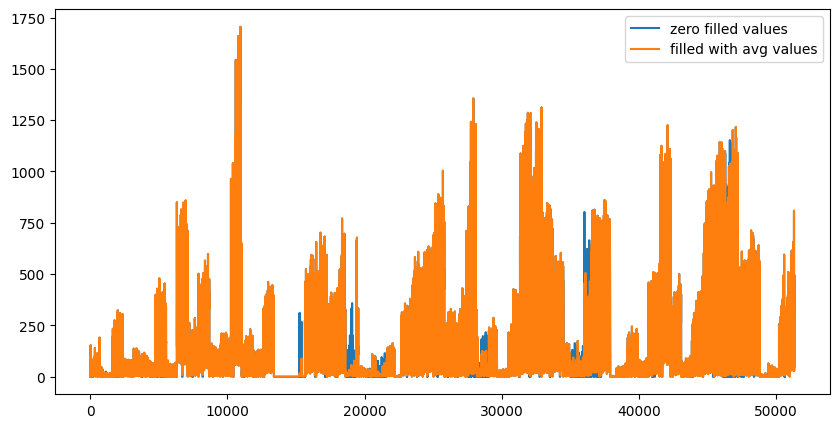

In [34]:
# 2018-01 10분 interval 탑승 빈도
plt.figure(figsize=(10, 5))
plt.plot(jan_2018_fill[0:51336], label = "zero filled values")
plt.plot(jan_2018_smooth[0:51336], label="filled with avg values")
plt.legend()
plt.show()

In [66]:
jan_2018_smooth = smoothing(jan_2018_groupby['trip_distance'].values, jan_2018_unique)
jan_2019_smooth = fill_missing(jan_2019_groupby['trip_distance'].values, jan_2019_unique)
feb_2019_smooth = fill_missing(feb_2019_groupby['trip_distance'].values, feb_2019_unique)
mar_2019_smooth = fill_missing(mar_2019_groupby['trip_distance'].values, mar_2019_unique)

# 2019 3개의 달을 합산한 리스트
regions_cum = []

# 2019 1월 = 744
# 2019 2월 = 672
# 2019 3월 = 722

for i in range(1, 70):
    regions_cum.append(jan_2019_smooth[744*(i-1):744*i]+jan_2019_smooth[672*(i-1):672*i]+mar_2019_smooth[744*(i-1):744*i])


In [67]:
print(len(regions_cum))
# 265
print(len(regions_cum[0]))
# 12960

69
2160


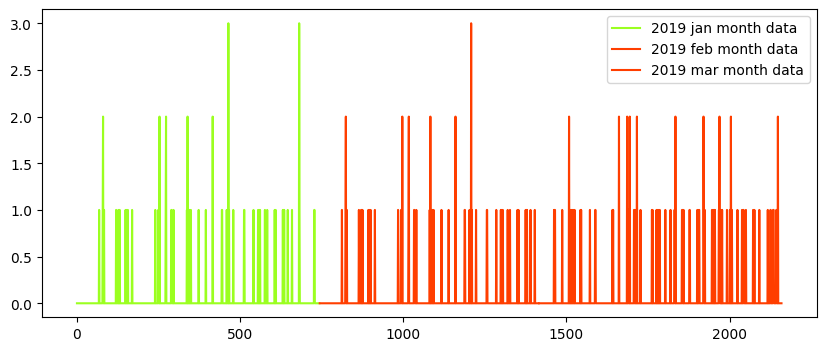

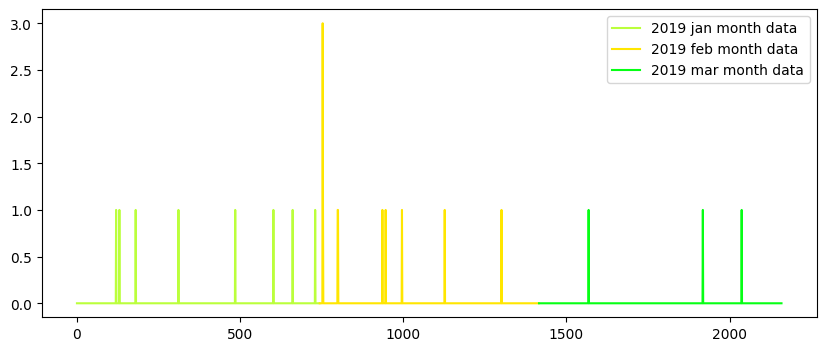

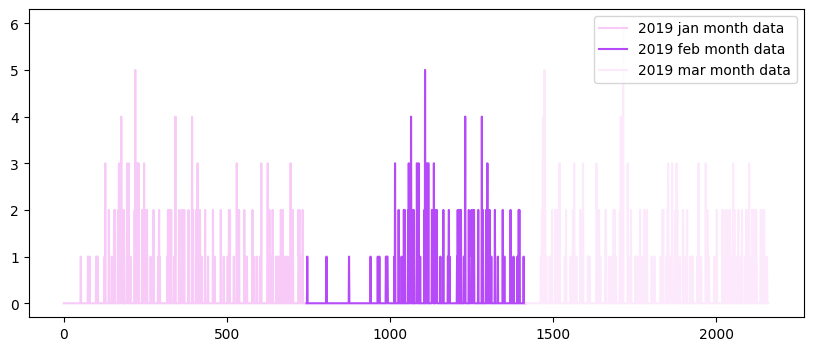

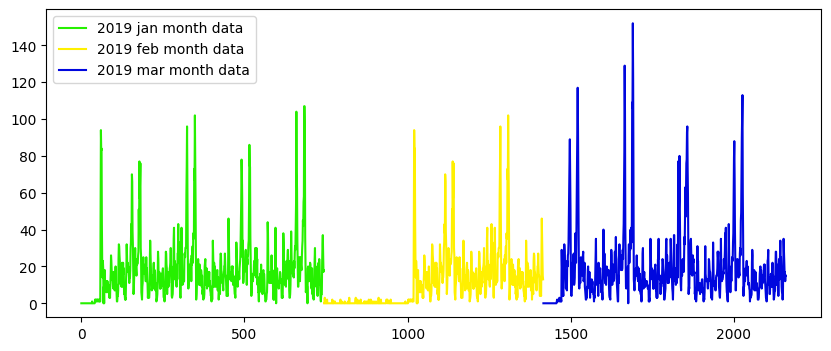

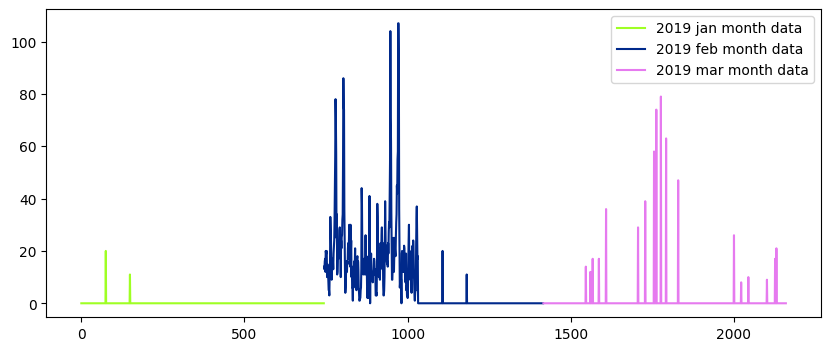

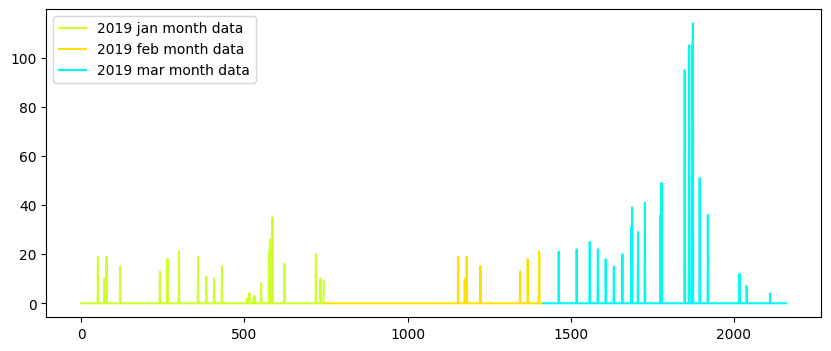

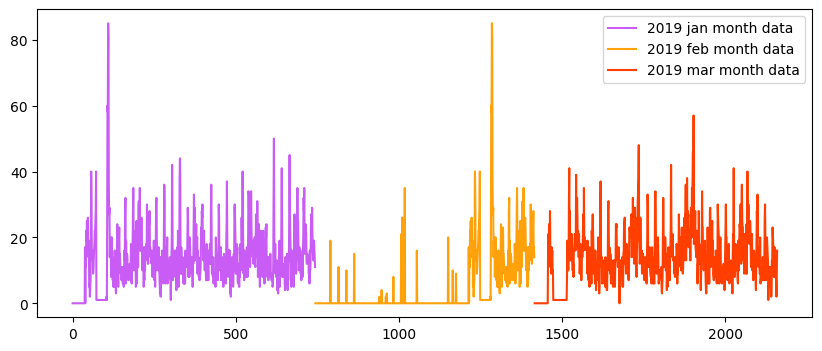

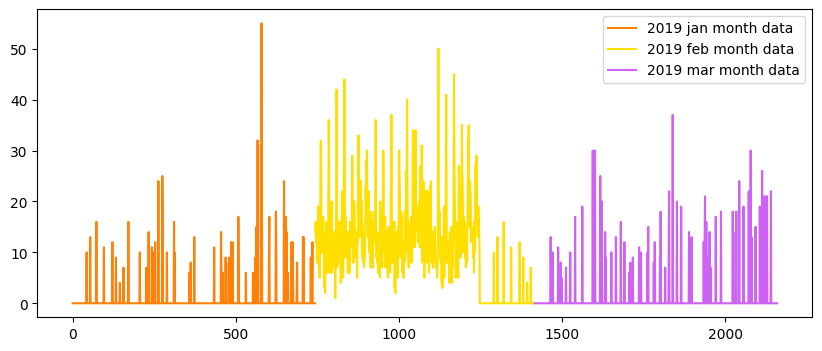

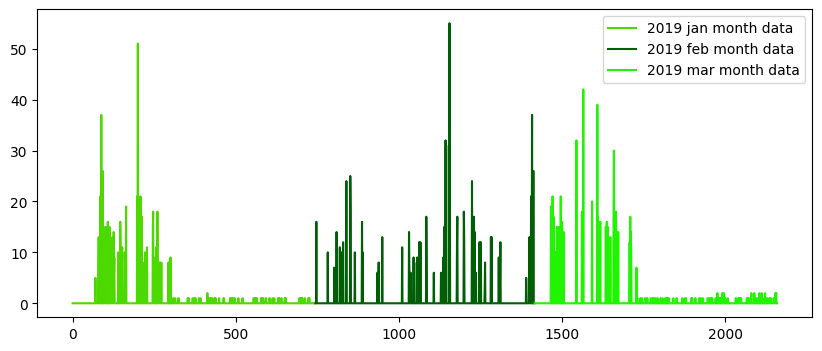

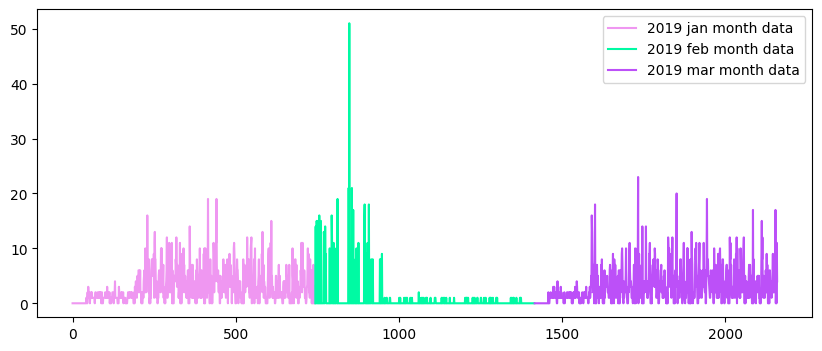

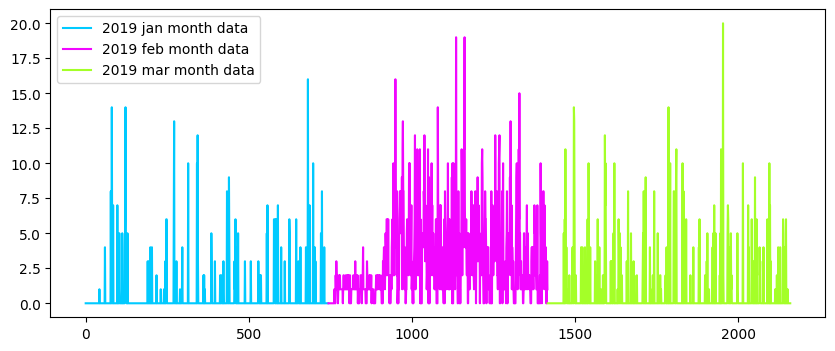

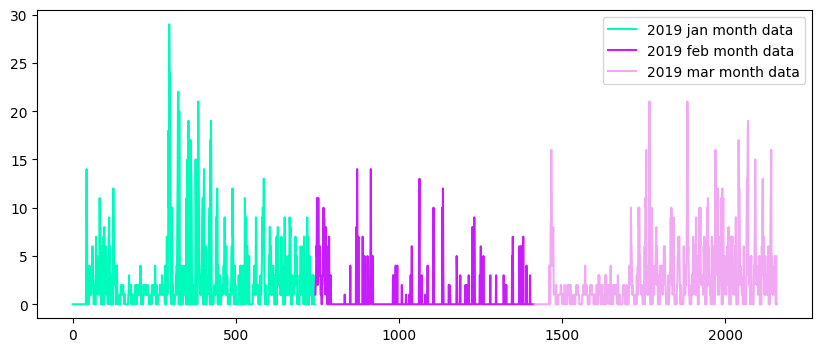

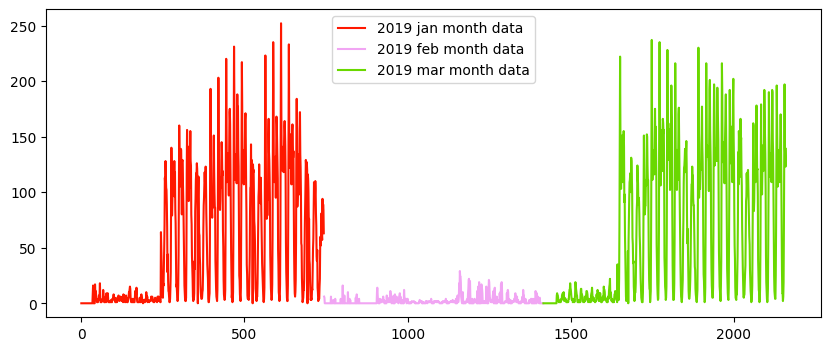

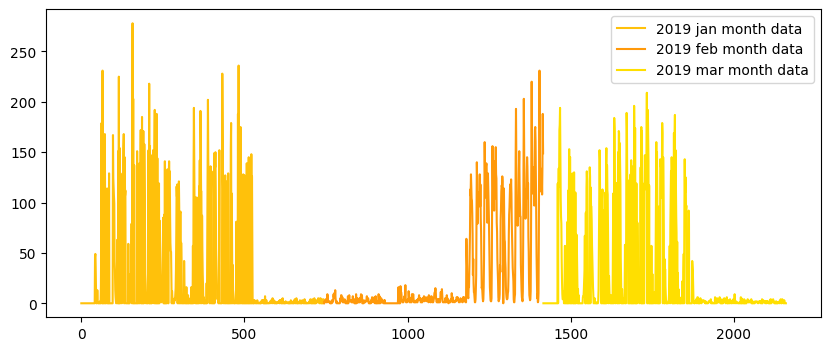

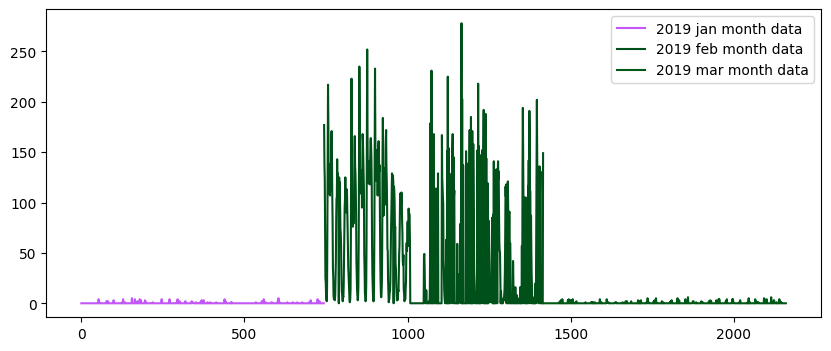

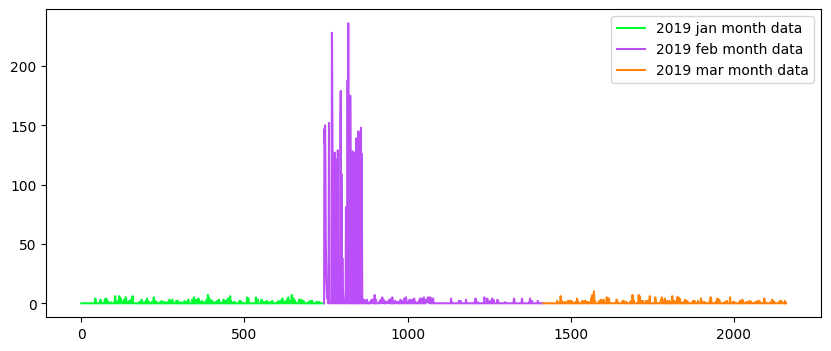

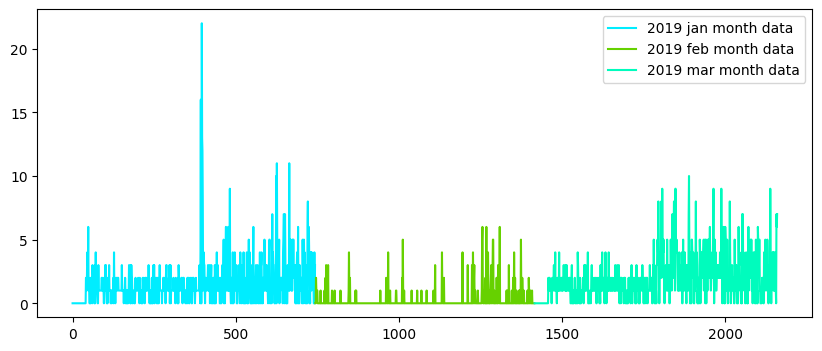

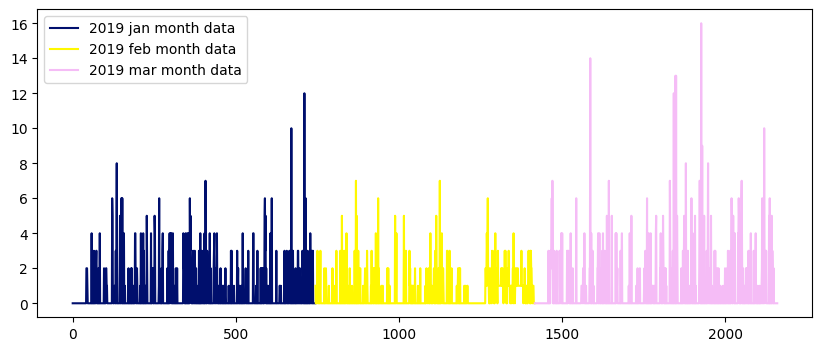

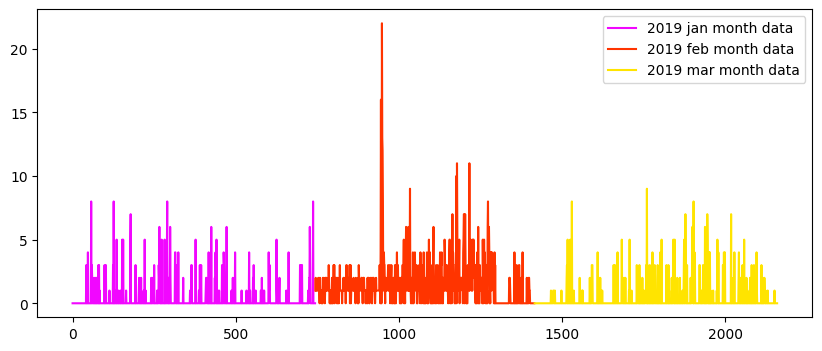

In [68]:
def uniqueish_color():
    # 랜덤 색상 주기
    return plt.cm.gist_ncar(np.random.random())

first_x = list(range(0, 744))
second_x = list(range(744, 1416))
third_x = list(range(1416, 2160))

for i in range(1, 20): # 지역별 월별 탑승 추이(반복문 숫자 바꿔서 지역 변경)
    plt.figure(figsize=(10, 4))
    plt.plot(first_x, regions_cum[i-1][:744], color=uniqueish_color(), label='2019 jan month data')
    plt.plot(second_x, regions_cum[i-1][744:1416], color=uniqueish_color(), label='2019 feb month data')
    plt.plot(third_x, regions_cum[i-1][1416:], color=uniqueish_color(), label='2019 mar month data')
    plt.legend()
    plt.show()

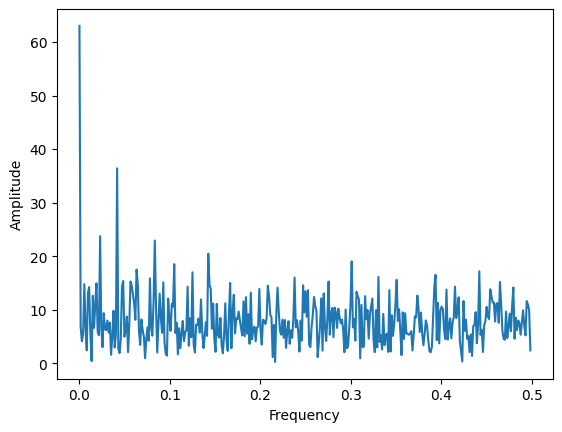

In [69]:
# 주파수 분석 -> 뭔지 모르겠음
Y = np.fft.fft(np.array(jan_2019_smooth)[0:744])

freq = np.fft.fftfreq(744, 1)
n = len(freq)
plt.figure()
plt.plot(freq[:int(n/2)], np.abs(Y)[:int(n/2)])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [70]:
# 2018 1월: 학습
# 2019 1월: 예측
ratios_jan = pd.DataFrame()
ratios_jan['Given'] = jan_2018_smooth
ratios_jan['Prediction'] = jan_2019_smooth
ratios_jan['Ratios'] = ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [71]:
print(ratios_jan.shape)

(51336, 3)


# modeling

1. R_t = P_t(2016) / P_t(2015)
2. 2019년도 알려진 값을 이용하여 예측

simple moving average

In [72]:
# 비율(ratios)를 이용
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,744*69):
        if i%744==0:# 시작시
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio) # 예상비율(simple moving average)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio)) # 예상 비율을 통한 다음 예상 값
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1)))) #예상값-실제값
        if i+1>=window_size: # 이전 시간 3개의 값을 통한 평균
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else: # 1,2,3의 경우는 데이터 부족이므로 0에서부터 평균
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    # mape 에러와 mse 에러
    # https://biology-statistics-programming.tistory.com/59
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [45]:
# 테스트값(predicted value)를 이용
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,744*69):
        predicted_values.append(predicted_value) # 예상값(simple  moving average)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:  # 이전 시간 window-size 만큼의 값을 통한 평균
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else: # 1,2,3의 경우는 데이터 부족이므로 0에서부터 평균
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

weighted moving averages

In [46]:
# ratio
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,744*69):
        if i%744==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j] # Weighted moving average
                sum_of_coeff+=j # N(N+1) / 2
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [47]:
# predicted value
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,744*69):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j] # Weighted moving average
                sum_of_coeff+=j # N(N+1)/ 2
            predicted_value=int(sum_values/sum_of_coeff)
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

Exponential Weighted Moving Averages

In [48]:
# ratio
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,744*69):
        if i%744==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i]) # Exponential Weighted Moving Averages
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [49]:
# predicted value
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,744*69):
        if i%744==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i])) # Exponential Weighted Moving Averages
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [73]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

In [74]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2019 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2019 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2019 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  1.5324284617076134       MSE:  179134.92745831385
Moving Averages (2019 Values) -                        MAPE:  0.4739469633472814        MSE:  678.687412342216
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  1.707259475497398       MSE:  197978.58154121865
Weighted Moving Averages (2019 Values) -               MAPE:  0.4840016826915416       MSE:  617.3702859591709
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  1.6185102443408343       MSE:  139865.06260713728
Exponential Moving Averages (2019 Values) -         MAPE:  0.479834790285005

Regression Model

In [75]:
print(len(regions_cum))

69


In [76]:
print(len(regions_cum[0]))

2160


In [77]:
print(np.array(regions_cum).shape)

(69, 2160)


In [78]:
# split train and test
# 2018 1월 = 744
# 2019 1월 = 744
# 2019 2월 = 672
# 2019 3월 = 744


# 마지막 5개의 interval 
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 12811 for each cluster
output = []


# 위도 경도 대신 목적지
tsne_destination = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 12811 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []

tsne_feature = [0]*number_of_time_stamps
for i in range(1, 70):
    # 위치별
    tsne_destination.append([i] * 2155)
    # 날짜별 
    tsne_weekday.append([int(((int(k/144))%7+2)%7) for k in range(5,744+672+744)])
    # 5 interval씩 나눠서 저장
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i-1][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i-1])-number_of_time_stamps)]))
    # 모든 interval 저장
    output.append(regions_cum[i-1][5:])
tsne_feature = tsne_feature[1:]

In [79]:
print(np.array(regions_cum).shape)

(69, 2160)


In [82]:
# 끝값 처리 필요ㅠ
np.array(regions_cum[68]).shape

(2160,)

In [83]:
# exponential moving averages 사용

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(1,70):
    for i in range(0,2160):
        if i==0: # 초기값
            predicted_value= regions_cum[r-1][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        # alpha * 이전값 + (1-alpha) * 현재값
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r-1][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [84]:
print("size of train data :", int(2155*0.7))
print("size of test data :", int(2155*0.3))

size of train data : 1508
size of test data : 646


In [85]:
# 7:3 비율로 훈련, 테스트 케이스 분리
train_features =  [tsne_feature[(i-1)*2155:(2155*(i-1)+1508)] for i in range(1,266)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(2155*(i-1))+1508:2155*(i)] for i in range(1,266)]

In [86]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

# 8967개의 훈련 케이스
# 3844개의 테스트 케이스

Number of data clusters 265 Number of data points in trian data 1508 Each data point contains 5 features
Number of data clusters 265 Number of data points in test data 647 Each data point contains 5 features


In [87]:
# 훈련
tsne_train_flat_destination = [i[:1508] for i in tsne_destination]
tsne_train_flat_weekday = [i[:1508] for i in tsne_weekday]
tsne_train_flat_output = [i[:1508] for i in output]
tsne_train_flat_exp_avg = [i[:1508] for i in predict_list]

In [88]:
# 테스트
tsne_test_flat_destination = [i[1508:] for i in tsne_destination]
tsne_test_flat_weekday = [i[1508:] for i in tsne_weekday]
tsne_test_flat_output = [i[1508:] for i in output]
tsne_test_flat_exp_avg = [i[1508:] for i in predict_list]

In [89]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(1, 70):
    train_new_features.extend(train_features[i-1])
test_new_features = []
for i in range(1, 70):
    test_new_features.extend(test_features[i-1])

In [90]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_destination = sum(tsne_train_flat_destination, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [91]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_destination = sum(tsne_test_flat_destination, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [92]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['destination'] = tsne_train_destination
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(104052, 8)


In [93]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns)
df_test['destination'] = tsne_test_destination
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(44643, 8)


In [94]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,destination,weekday,exp_avg
0,2,0,0,0,1,1,5,0
1,0,0,0,1,0,1,5,0
2,0,0,1,0,0,1,5,0
3,0,1,0,0,1,1,5,0
4,1,0,0,1,0,1,5,0


In [95]:
# 선형회귀 모델

from sklearn.linear_model import LinearRegression
# 학습
lr_reg=LinearRegression().fit(df_train, tsne_train_output)

# 예측
y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

In [96]:
# 랜덤포레스트

# max_features: 최대 feature 수
# min_samples_leaf: 리프노드의 최소 데이터 수
# min_samples_split: 노드를 분할하기 위한 최소 데이터 수(이 수치 이상이면 분할)
# n_estimators: 결정트리 개수
# n_jobs: cpu 코어 수
regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [97]:

print(df_train.columns)
# 특성 중요도
# ft_1이 가장 중요 -> 바로 직전에 탔던 시간이 중요
# exp_avg이 다음으로 중요 -> 마찬가지
print(regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'destination', 'weekday',
       'exp_avg'],
      dtype='object')
[0.06479056 0.07853972 0.08194138 0.16797759 0.25869524 0.01951504
 0.00678588 0.32175459]


In [98]:
x_model = xgb.XGBRegressor(
# 학습률
 learning_rate =0.1,
 # weak learner = 학습 기준
 n_estimators=1000,
 # 트리의 깊이
 max_depth=3,
 # 관측치에 가중치 합 최소
 min_child_weight=3,
 # 단말노드의 추가분할 결정할 최소손실 감소값
 # 해당값보다 손실이 크게 감소하면 분리
 gamma=0,
 # 데이터 샘플링 비율(불균형 낮춤)
 subsample=0.8,
 # l1 규제 -> lasso(과적합 방지)
 # l2 규제 -> ridge(과적합 방지)
 reg_alpha=200, reg_lambda=200,
 # feature 생플링
 # 스레드 실행 개수
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=200, ...)

In [99]:
y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [100]:
#특성 중요도
# ft_1이 중요 -> 이전 interval 탑승 수 중요
# destination 중요 -> 탑승 위치 중요
x_model.get_booster().get_score(importance_type='weight')

{'ft_5': 1055.0,
 'ft_4': 1019.0,
 'ft_3': 1084.0,
 'ft_2': 1086.0,
 'ft_1': 1170.0,
 'destination': 288.0,
 'weekday': 176.0,
 'exp_avg': 1018.0}

In [101]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [102]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.47129764793080414       Test:  0.4449589900997572
Exponential Averages Forecasting -           Train:  0.4779682997904267       Test:  0.4556187337249821
Linear Regression -                         Train:  0.43645188970627774       Test:  0.4682959505868441
Random Forest Regression -                   Train:  0.3184470529186343      Test:  0.4548623778194306


In [104]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])
print ("XgBoost Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.47129764793080414       Test:  0.4449589900997572
Exponential Averages Forecasting -           Train:  0.4779682997904267       Test:  0.4556187337249821
Linear Regression -                         Train:  0.5244360653207938       Test:  0.49347898557105657
Random Forest Regression -                   Train:  0.3184470529186343      Test:  0.4548623778194306
XgBoost Regression -                         Train:  0.43645188970627774       Test:  0.4682959505868441
--------------------------------------------------------------------------------------------------------


10분 interval일 때보다 정확도가 낮아짐..